In [ ]:
pip install spark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for spark: filename=spark-0.2.1-py3-none-any.whl size=58760 sha256=84884d5fcd0f2e84c903cb259e2840f94944d6d48588f6093a447c8e33ece3e7
  Stored in directory: /root/.cache/pip/wheels/bc/0f/6c/b41528ca0fd4d46513185e90da91bc1c484bba6138641c5a62
Successfully built spark


In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=f235c29d7e0b8f0bb255e04e3856eff487fbaa4b214439aea3a2a7c7fb4f36e1
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]"). appName('bikes').getOrCreate()


In [ ]:
spark

In [ ]:
# reading dataset 
from google.colab import files
uploaded = files.upload()

Saving Dataset-2017-fordgobike-tripdata.csv to Dataset-2017-fordgobike-tripdata.csv


In [ ]:
df = spark.read.option('header','true') .csv("Dataset-2017-fordgobike-tripdata.csv")

In [ ]:
df.show()

+----------+--------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+
|start_time|end_time|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|end_station_id|    end_station_name|end_station_latitude|end_station_longitude|bike_id| user_type|member_birth_year|member_gender|     pyment|
+----------+--------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+
|   57:39.7| 12:50.2|              74|Laguna St at Haye...|           37.77643482|            -122.426244|            43|San Francisco Pub...|          37.7787677|         -122.4159292|     96|  Customer|             1987|         Male|credit card|
|   

In [ ]:
df.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- pyment: string (nullable = true)



In [ ]:
df.count()

519700

In [ ]:
# columns= df.columns
# for col in columns:
#     print("total count of",col,":    ",df.select(col).dropna().count())

In [ ]:
df.groupBy('member_gender').count().show()

+-------------+------+
|member_gender| count|
+-------------+------+
|         null| 66462|
|       Female| 98621|
|        Other|  6299|
|         Male|348318|
+-------------+------+



In [ ]:
df.groupBy('member_gender').count().orderBy('count', ascending=False).show()

+-------------+------+
|member_gender| count|
+-------------+------+
|         Male|348318|
|       Female| 98621|
|         null| 66462|
|        Other|  6299|
+-------------+------+



In [ ]:
##calculate distance of each trip using haversine library and add the result to the dataset 

In [ ]:
pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql.functions import when, udf
from pyspark.sql.types import DoubleType
from haversine import haversine, Unit

# Define a UDF to calculate the distance between two points
@udf(returnType=DoubleType())
def calculate_distance(lat1, lon1, lat2, lon2):
    if lat1 is None or lon1 is None or lat2 is None or lon2 is None:
        return None
    start = (float(lat1), float(lon1))
    end = (float(lat2), float(lon2))
    distance = haversine(start, end, unit=Unit.METERS)
    return distance

# Add a new column to the dataset with the distance for each trip
df_distance = df.withColumn("distance", when((df.start_station_longitude == df.end_station_longitude) & (df.start_station_latitude == df.end_station_latitude), 0).otherwise(calculate_distance(df.start_station_latitude, df.start_station_longitude, df.end_station_latitude, df.end_station_longitude)))

df_distance.show()


+----------+--------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+--------------------+--------------------+------------+------------------+------------------+
|start_time|end_time|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|end_station_id|    end_station_name|end_station_latitude|end_station_longitude|bike_id| user_type|member_birth_year|member_gender|    payment|       start_time_ts|         end_time_ts|duration_sec|      duration_min|          distance|
+----------+--------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+--------------------+--------------------+------------+-------------

In [ ]:
df_distance.describe('distance').show()

+-------+------------------+
|summary|          distance|
+-------+------------------+
|  count|            519700|
|   mean| 1587.078983279039|
| stddev|1010.3926923194346|
|    min|               0.0|
|    max| 68186.88112766335|
+-------+------------------+



In [ ]:
## total distance each bike had made 

In [ ]:

from pyspark.sql.functions import sum , round
total_distance_per_bike = df_distance.groupBy("bike_id") \
    .agg(round(sum("distance")/1000, 2).alias("total_distance_km"))

# Show the results with ordering by the total distance to find the most used bikes that need to fix 
total_distance_per_bike.orderBy('total_distance_km',ascending=False ) .show(10)

+-------+-----------------+
|bike_id|total_distance_km|
+-------+-----------------+
|     68|           743.37|
|   2178|           721.18|
|    256|           671.92|
|    235|           670.16|
|   2049|           656.83|
|    441|           656.64|
|   2226|           647.82|
|    796|           646.87|
|    190|           640.29|
|   2365|           639.41|
+-------+-----------------+
only showing top 10 rows



In [ ]:
# ## plotting total distance for each bike 

# # Set the color palette
# palette_colors = ["#d4c4a5", "#7eb0db"]

# sns.set_palette(palette_colors)

# # Create the bar plot
# ax = sns.barplot(x="bike_id", y="total_distance", data=top_10_bikes, palette=palette_colors)

# # Rotate the x-axis labels by 45 degrees
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# # Set the title and axis labels
# ax.set_title("Total Distance per Bike (Top 10 Bikes)")
# ax.set_xlabel("Bike ID (Top 10)")
# ax.set_ylabel("Total Distance (km)")

# # Show the plot
# plt.show()





In [ ]:
## how many trips each bike has made 
from pyspark.sql.functions import count
trips_per_bike = df.groupBy("bike_id").agg(count("*").alias("trips_count"))
trips_per_bike.orderBy('trips_count',ascending=False ) .show(10)


+-------+-----------+
|bike_id|trips_count|
+-------+-----------+
|     68|        457|
|   2178|        426|
|    210|        408|
|    813|        403|
|    602|        402|
|    775|        399|
|    256|        396|
|    796|        396|
|    395|        396|
|    190|        395|
+-------+-----------+
only showing top 10 rows



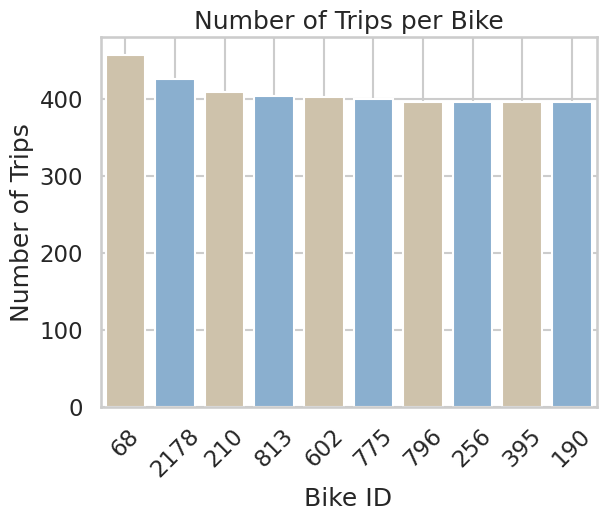

<Figure size 800x600 with 0 Axes>

In [ ]:
## plot the number of trips each bike 
trips_per_bike_pd= trips_per_bike.orderBy('trips_count',ascending=False ).limit(10).toPandas()
import seaborn as sns 
import matplotlib.pyplot as plt
palette_colors = ["#d4c4a5", "#7eb0db"]

# Create the bar plot
ax = sns.barplot(x="bike_id", y="trips_count", data=trips_per_bike_pd, palette=palette_colors)
# Set the title and axis labels
ax.set_title("Number of Trips per Bike")
ax.set_xlabel("Bike ID")
ax.set_ylabel("Number of Trips")

# Add grid lines to the chart
ax.grid(True)

# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.figure(figsize=(8, 6))
# Show the plot
plt.show()

<ipython-input-78-4248ccbbd74b>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


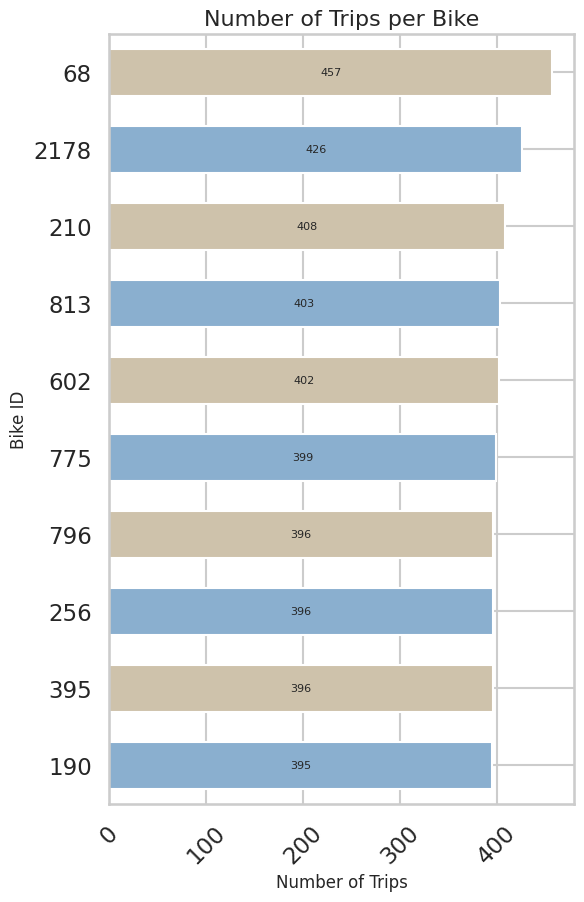

In [ ]:
# replotting as horisental 
plt.figure(figsize=(6, 10))
ax = sns.barplot(x="trips_count", y="bike_id", data=trips_per_bike_pd, palette=palette_colors,  width=0.6 , orient='h')

# Add data labels to the bars
for i, bar in enumerate(ax.containers):
    ax.bar_label(bar, label_type='center', labels=trips_per_bike_pd['trips_count'].values, fontsize=8)

# Set the title and axis labels
ax.set_title("Number of Trips per Bike", fontsize=16)
ax.set_ylabel("Bike ID", fontsize=12)
ax.set_xlabel("Number of Trips", fontsize=12)

# Add grid lines to the chart
ax.grid(True)

# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Show the plot
plt.show()



In [ ]:
## total distance and number of trips for each bike together 
# Join with the trips DataFrame to get the number of trips for each bike
total_distance_per_bike = total_distance_per_bike.join(trips_per_bike, "bike_id")

# Show the results with ordering by the number of trips to find the most frequently used bikes
total_distance_per_bike.orderBy('total_distance_km',ascending=False ) .select('bike_id','trips_count','total_distance_km').show(10)

+-------+-----------+-----------------+
|bike_id|trips_count|total_distance_km|
+-------+-----------+-----------------+
|     68|        457|           743.37|
|   2178|        426|           721.18|
|    256|        396|           671.92|
|    235|        386|           670.16|
|   2049|        394|           656.83|
|    441|        379|           656.64|
|   2226|        383|           647.82|
|    796|        396|           646.87|
|    190|        395|           640.29|
|   2365|        354|           639.41|
+-------+-----------+-----------------+
only showing top 10 rows



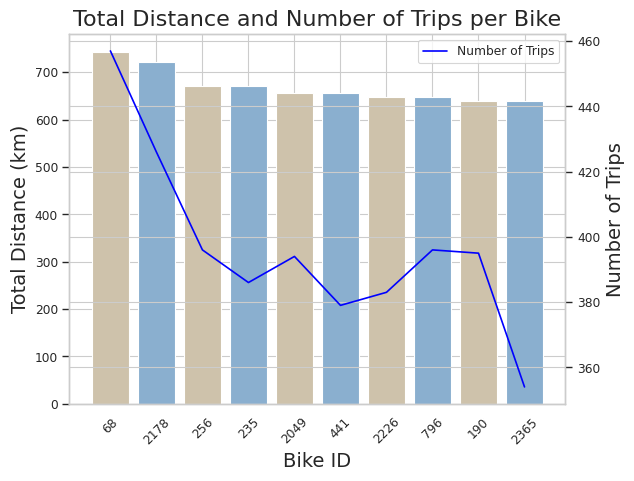

In [ ]:
## plot the joined dataframe 
import seaborn as sns 
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame
total_distance_per_bike_pd = total_distance_per_bike.orderBy("total_distance_km", ascending=False).limit(10).toPandas()

# Define the colors for the plot
palette_colors = ["#d4c4a5", "#7eb0db"]

# Create the bar plot
sns.set_context("paper", rc={"bar_width":0.7})
ax = sns.barplot(x="bike_id", y="total_distance_km", data=total_distance_per_bike_pd.head(10), palette=palette_colors)

# Add a second y-axis for the number of trips
ax2 = ax.twinx()
sns.lineplot(x="bike_id", y="trips_count", data=total_distance_per_bike_pd, ax=ax2, color="blue")

# Set the title and axis labels
ax.set_title("Total Distance and Number of Trips per Bike", fontsize=16)
ax.set_xlabel("Bike ID", fontsize=14)
ax.set_ylabel("Total Distance (km)", fontsize=14)
ax2.set_ylabel("Number of Trips", fontsize=14)

# Add grid lines to the chart
ax.grid(True)

# Add a legend to the chart
ax2.legend(["Number of Trips"], loc="upper right")

# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Show the plot
plt.show()






In [ ]:
# total distance for each gender group 
from pyspark.sql.functions import avg
df_distance.filter(df_distance.member_gender!="").groupBy('member_gender').agg(avg('distance')).show()

+-------------+------------------+
|member_gender|     avg(distance)|
+-------------+------------------+
|       Female|1666.4314539780637|
|        Other|1602.5667309657013|
|         Male|1580.4789958963756|
+-------------+------------------+



In [ ]:
##create duration columns with seconds and minutes then calculate the fee for min=0.35 $

In [ ]:
##edit time format 
from pyspark.sql.functions import  col ,to_timestamp
df = df.withColumn("start_time_ts", to_timestamp(col("start_time"), "mm:ss.S")) \
    .withColumn("end_time_ts", to_timestamp(col("end_time"), "mm:ss.S"))

In [ ]:
df.show()

+----------+--------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+--------------------+--------------------+------------+------------------+
|start_time|end_time|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|end_station_id|    end_station_name|end_station_latitude|end_station_longitude|bike_id| user_type|member_birth_year|member_gender|    payment|       start_time_ts|         end_time_ts|duration_sec|      duration_min|
+----------+--------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+--------------------+--------------------+------------+------------------+
|   57:39.7| 12:50.2|          

In [ ]:
from pyspark.sql.functions import unix_timestamp, col, when

# Calculate the duration in seconds , adding 1 hour to the end time if it is smaller than the start time 
df = df.withColumn("duration_sec",  when(col("start_time_ts") > col("end_time_ts"), 
                                          unix_timestamp(col("end_time_ts")) + 3600 - unix_timestamp(col("start_time_ts")))
                                      .otherwise(unix_timestamp(col("end_time_ts")) - unix_timestamp(col("start_time_ts"))))

# Calculate the duration in minutes and fees
df = df.withColumn("duration_min", col("duration_sec")/60)
df_fee = df.withColumn("fee", col("duration_min") * 0.35)





In [ ]:
df_fee.show()

+----------+--------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+--------------------+--------------------+------------+------------------+------------------+
|start_time|end_time|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|end_station_id|    end_station_name|end_station_latitude|end_station_longitude|bike_id| user_type|member_birth_year|member_gender|    payment|       start_time_ts|         end_time_ts|duration_sec|      duration_min|               fee|
+----------+--------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+--------------------+--------------------+------------+-------------

In [ ]:
df_fee.select("duration_sec","duration_min","fee").orderBy(col('fee').desc()).show()

+------------+------------------+------------------+
|duration_sec|      duration_min|               fee|
+------------+------------------+------------------+
|        3600|              60.0|              21.0|
|        3599|59.983333333333334|20.994166666666665|
|        3599|59.983333333333334|20.994166666666665|
|        3599|59.983333333333334|20.994166666666665|
|        3599|59.983333333333334|20.994166666666665|
|        3599|59.983333333333334|20.994166666666665|
|        3599|59.983333333333334|20.994166666666665|
|        3599|59.983333333333334|20.994166666666665|
|        3598| 59.96666666666667|20.988333333333333|
|        3598| 59.96666666666667|20.988333333333333|
|        3598| 59.96666666666667|20.988333333333333|
|        3598| 59.96666666666667|20.988333333333333|
|        3598| 59.96666666666667|20.988333333333333|
|        3598| 59.96666666666667|20.988333333333333|
|        3597|             59.95|20.982499999999998|
|        3597|             59.95|20.9824999999

In [ ]:
df_fee.describe('fee').show()

+-------+------------------+
|summary|               fee|
+-------+------------------+
|  count|            519700|
|   mean| 4.306694888076455|
| stddev|3.1647470389969548|
|    min|               0.0|
|    max|              21.0|
+-------+------------------+



In [ ]:
#total trips in each start station 
trips_start_station = df.groupBy("start_station_name").agg(count("*").alias("total_start_trips"))
trips_start_station.orderBy("total_start_trips", ascending=False).show(10)

+--------------------+-----------------+
|  start_station_name|total_start_trips|
+--------------------+-----------------+
|San Francisco Fer...|            15187|
|The Embarcadero a...|            13664|
|San Francisco Cal...|            12546|
|San Francisco Cal...|            12055|
|Market St at 10th St|            11960|
|Montgomery St BAR...|            11334|
|  Berry St at 4th St|            10956|
|Powell St BART St...|            10142|
|Howard St at Beal...|             9926|
|Steuart St at Mar...|             9347|
+--------------------+-----------------+
only showing top 10 rows



<ipython-input-90-121ad0f343ed>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), ha="right")
<ipython-input-90-121ad0f343ed>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)


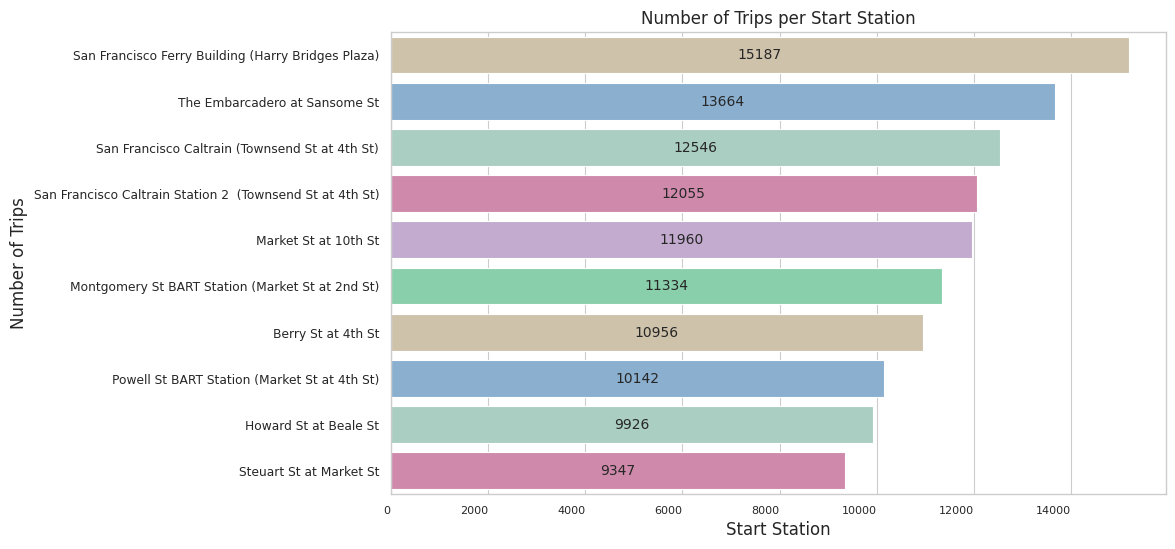

In [ ]:
# Set the plot style
trips_start_station_pd = trips_start_station.orderBy("total_start_trips", ascending=False).limit(10).toPandas()

sns.set_style("whitegrid")

# Set the figure size
plt.figure(figsize=(10, 6))
palette_colors = ["#d4c4a5", "#7eb0db" ,"#a5d4c4","#db7eaa","#c4a5d4","#7edbaa"]
# Create the bar plot
ax = sns.barplot(x="total_start_trips", y="start_station_name", data=trips_start_station_pd, palette=palette_colors ,   orient='h')

# Set the title and axis labels
ax.set_title("Number of Trips per Start Station", fontsize=12)
ax.set_xlabel("Start Station", fontsize=12)
ax.set_ylabel("Number of Trips", fontsize=12)

# Add data labels to the bars
for i, bar in enumerate(ax.containers):
    ax.bar_label(bar, label_type='center', labels=trips_start_station_pd['total_start_trips'].values, fontsize=10)

# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), ha="right")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
# Show the plot
plt.show()



In [ ]:
#total trips in each end station 
trips_end_station = df.groupBy("end_station_name").agg(count("*").alias("total_end_trips"))
trips_end_station.orderBy("total_end_trips", ascending=False).show(10)

+--------------------+---------------+
|    end_station_name|total_end_trips|
+--------------------+---------------+
|San Francisco Cal...|          17378|
|San Francisco Fer...|          17109|
|The Embarcadero a...|          16531|
|San Francisco Cal...|          13658|
|Montgomery St BAR...|          13443|
|Market St at 10th St|          11298|
|Powell St BART St...|          11064|
|  Berry St at 4th St|          10611|
|Steuart St at Mar...|           9321|
|Powell St BART St...|           8563|
+--------------------+---------------+
only showing top 10 rows



<ipython-input-92-84b52c0c2927>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), ha="right")
<ipython-input-92-84b52c0c2927>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)


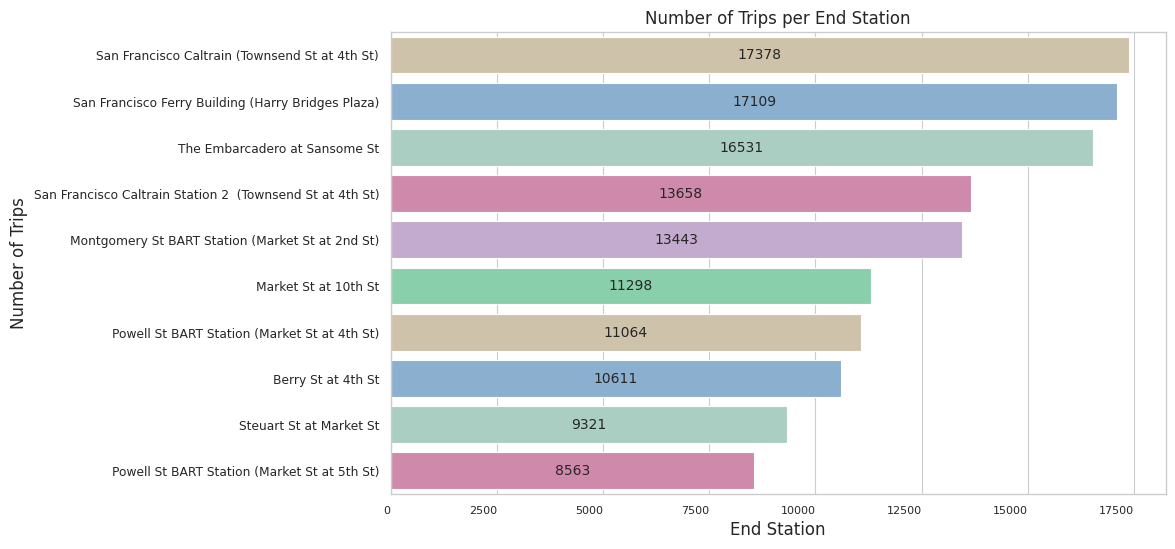

In [ ]:
# Set the plot style
trips_end_station_pd = trips_end_station.orderBy("total_end_trips", ascending=False).limit(10).toPandas()

sns.set_style("whitegrid")

# Set the figure size
plt.figure(figsize=(10, 6))
palette_colors = ["#d4c4a5", "#7eb0db" ,"#a5d4c4","#db7eaa","#c4a5d4","#7edbaa"]
# Create the bar plot
ax = sns.barplot(x="total_end_trips", y="end_station_name", data=trips_end_station_pd, palette=palette_colors ,   orient='h')

# Set the title and axis labels
ax.set_title("Number of Trips per End Station", fontsize=12)
ax.set_xlabel("End Station", fontsize=12)
ax.set_ylabel("Number of Trips", fontsize=12)

# Add data labels to the bars
for i, bar in enumerate(ax.containers):
    ax.bar_label(bar, label_type='center', labels=trips_end_station_pd['total_end_trips'].values, fontsize=10)

# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), ha="right")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
# Show the plot
plt.show()

In [ ]:
## - calculate the number of trips for each start station list top 10 and find the ratio of using as male or female (careful wat u gonna drop)

In [ ]:
from pyspark.sql.functions import col, count, avg, desc

# Count the number of trips per start station and user gender
trips_per_start_station = df.groupBy("start_station_name", "member_gender").agg(count("*").alias("total_trips"))

# Clean the gender column
trips_per_start_station = trips_per_start_station.dropna(subset=['member_gender'])

# Group by start station and gender and calculate the average number of trips
avg_trips_per_start_station_gender = trips_per_start_station.groupBy("start_station_name", 'member_gender') \
    .agg(avg("total_trips").alias("avg_trips_g")) \
    .orderBy(desc("avg_trips_g"))



In [ ]:
## the ratio for gender 

In [ ]:
# Group by start station and pivot on gender to create columns of avg_trips_g for each gender
avg_trips_per_start_station_gender = avg_trips_per_start_station_gender.groupBy("start_station_name") \
    .pivot("member_gender") \
    .agg(avg("avg_trips_g")) \
    

avg_trips_per_start_station_gender.show()

+--------------------+------+------+-----+
|  start_station_name|Female|  Male|Other|
+--------------------+------+------+-----+
|College Ave at Ha...| 222.0| 419.0| 40.0|
|5th St at Brannan St| 169.0|1478.0|195.0|
|19th St at Florid...| 218.0|1175.0| 64.0|
|Townsend St at 7t...|1111.0|4836.0| 56.0|
|Shattuck Ave at H...| 126.0| 433.0|  7.0|
|Valencia St at Ce...| 419.0|1034.0| 13.0|
|San Salvador St a...| 108.0| 345.0|  2.0|
|53rd St at Hollis St|  22.0| 108.0| null|
|  12th St at 4th Ave| 155.0| 573.0| 83.0|
|Spear St at Folso...| 664.0|3765.0| 52.0|
|Folsom St at 15th St| 254.0|1207.0| 23.0|
|49th St at Telegr...| 239.0| 829.0| 11.0|
|Washington St at ...| 351.0|1071.0| 19.0|
|West Oakland BART...| 317.0| 736.0| 34.0|
|Jackson St at 11t...|  null|   1.0|  1.0|
|El Embarcadero at...| 848.0|1623.0| 63.0|
|San Francisco Fer...|2819.0|8586.0|104.0|
|The Embarcadero a...| 920.0|1722.0| 16.0|
|59th St at Horton St|  39.0| 186.0|  4.0|
|Grand Ave at Perk...| 803.0|1736.0| 23.0|
+----------

In [ ]:
## join to plot the gender per each station with the total start trips 
# Join the two data frames
joined_df1 = trips_start_station.join(avg_trips_per_start_station_gender, "start_station_name", "outer")

# Order the result by the "total_start_trips" column
joined_df1.orderBy(desc("total_start_trips")).show(10)


+--------------------+-----------------+------+------+-----+
|  start_station_name|total_start_trips|Female|  Male|Other|
+--------------------+-----------------+------+------+-----+
|San Francisco Fer...|            15187|2819.0|8586.0|104.0|
|The Embarcadero a...|            13664|1938.0|7444.0|119.0|
|San Francisco Cal...|            12546|2035.0|9813.0| 81.0|
|San Francisco Cal...|            12055|2105.0|9409.0|113.0|
|Market St at 10th St|            11960|1870.0|9005.0| 35.0|
|Montgomery St BAR...|            11334|1631.0|8367.0| 43.0|
|  Berry St at 4th St|            10956|2302.0|7773.0| 65.0|
|Powell St BART St...|            10142|1768.0|6070.0| 64.0|
|Howard St at Beal...|             9926|1980.0|7512.0|114.0|
|Steuart St at Mar...|             9347|1740.0|6532.0| 97.0|
+--------------------+-----------------+------+------+-----+
only showing top 10 rows



In [ ]:

## ratio for all genders in general 

# Calculate the total number of trips for each gender
total_trips_per_gender = trips_per_start_station.groupBy("member_gender").agg(count("*").alias("total_trips"))

# Calculate the total number of trips for all genders
total_trips_all_genders = total_trips_per_gender.agg(sum("total_trips")).collect()[0][0]
# Calculate the ratio of trips for each gender
ratio_per_gender = total_trips_per_gender.withColumn("ratio", col("total_trips") / total_trips_all_genders)

# Show the results
ratio_per_gender.show()




+-------------+-----------+-------------------+
|member_gender|total_trips|              ratio|
+-------------+-----------+-------------------+
|       Female|        269| 0.3484455958549223|
|        Other|        231|0.29922279792746115|
|         Male|        272|0.35233160621761656|
+-------------+-----------+-------------------+



In [ ]:
## make a comparison to find the percentage of usage for customer and subscriber 

In [ ]:
from pyspark.sql.functions import sum, expr, window

# Group the trips by user type and calculate the total duration
total_duration_by_user_type = (
    df.groupBy("user_type")
    .agg(expr("sum(duration_min) as total_duration"))
)

# Calculate the percentage of usage for each user type
trips_by_user_type = (
    df.groupBy("user_type")
    .agg(expr("count(*) as total_trips_users"))
    .join(total_duration_by_user_type, "user_type")
    .withColumn(
        "percentage_of_usage",
        expr("total_trips_users / sum(total_trips_users) over () * 100")
    )
)

# Show the results
trips_by_user_type.show()





+----------+-----------------+------------------+-------------------+
| user_type|total_trips_users|    total_duration|percentage_of_usage|
+----------+-----------------+------------------+-------------------+
|Subscriber|           409230| 4250283.849999972|  78.74350586877044|
|  Customer|           110470|2144542.8166666646| 21.256494131229555|
+----------+-----------------+------------------+-------------------+



<ipython-input-101-9e3195cc3ab8>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])


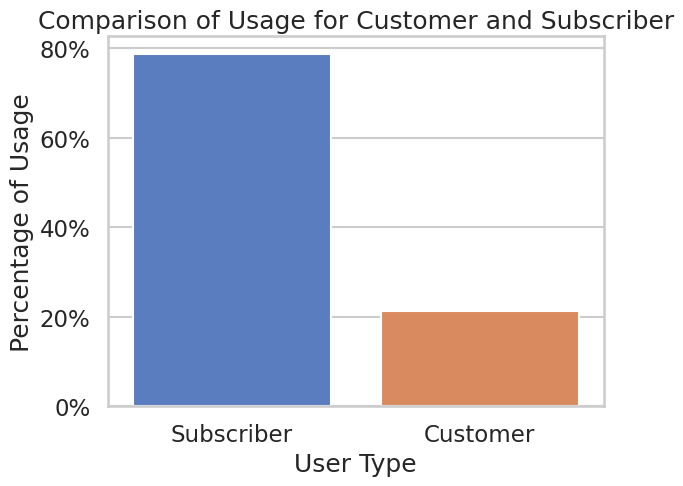

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a color palette for the plot
colors = sns.color_palette("muted")

# Convert the Spark DataFrame to a Pandas DataFrame
trips_by_user_type_pd = trips_by_user_type.toPandas()

# Set the plot style and context
sns.set_style("whitegrid")
sns.set_context("talk")

# Create the plot
ax = sns.barplot(x="user_type", y="percentage_of_usage", data=trips_by_user_type_pd, palette=colors)

# Set the plot title and axis labels
ax.set_title("Comparison of Usage for Customer and Subscriber")
ax.set_xlabel("User Type")
ax.set_ylabel("Percentage of Usage")

# Set the x and y axis tick labels
ax.set_xticklabels(["Subscriber", "Customer"])
ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])

# Show the plot
plt.show()




In [ ]:
## combining payment methods for subscribers and customers with ratio of usage 

In [ ]:
df = df.withColumnRenamed("pyment", "payment")

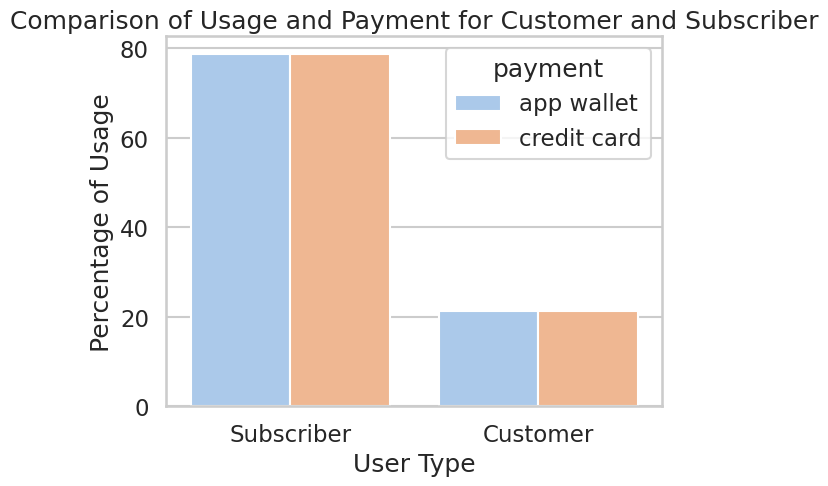

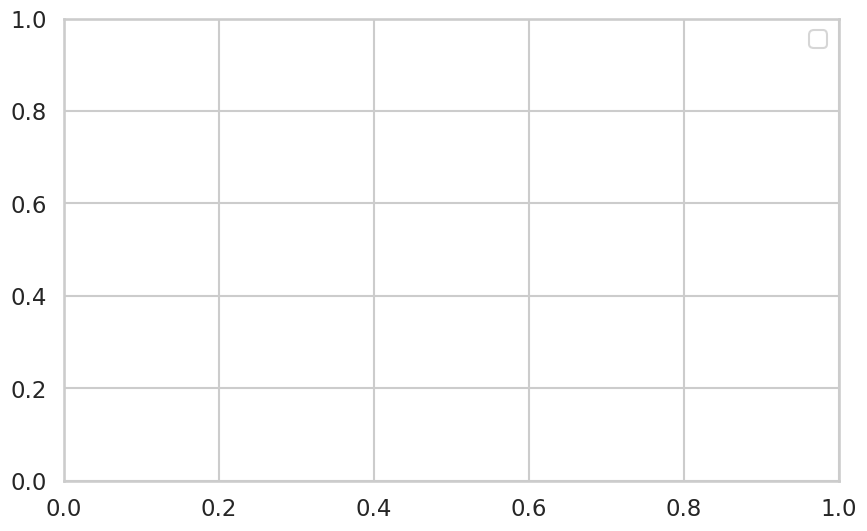

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Group the trips by user type and payment type and calculate the count
payment_counts = df.groupBy('user_type', 'payment').agg(count("*").alias("count"))

# Join the two dataframes on user_type column
df_joined = trips_by_user_type.join(payment_counts, "user_type")

# Convert the Spark DataFrame to a Pandas DataFrame
df_joined_pd = df_joined.toPandas()

# Plot the results using Seaborn
sns.set_style("whitegrid")
ax = sns.barplot(x="user_type", y="percentage_of_usage", hue="payment", data=df_joined_pd)

# Set the title and axis labels
ax.set_title("Comparison of Usage and Payment for Customer and Subscriber")
ax.set_xlabel("User Type")
ax.set_ylabel("Percentage of Usage")

# Set the figure size and adjust the legend location
plt.figure(figsize=(10,6))
plt.legend(loc='upper right')

# Show the plot
plt.show()


In [ ]:
## age of users and the relation between age and distance 

In [ ]:
df.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- payment: string (nullable = true)
 |-- start_time_ts: timestamp (nullable = true)
 |-- end_time_ts: timestamp (nullable = true)
 |-- duration_sec: long (nullable = true)
 |-- duration_min: double (nullable = true)



In [ ]:
from pyspark.sql.functions import year, current_date, round

# Calculate age of users based on birth year
df_with_age = df_distance.withColumn("age", year(current_date()) - year(col("member_birth_year")))

# cleaning the new dataframe
df_with_age = df_with_age.dropna(subset=["age", "distance"])
# Filter out ages above 80
df_with_age = df_with_age.filter(col("age") <= 80)

# Select only relevant columns and round age to nearest integer
df_age_distance = df_with_age.select(round(col("age")).alias("age"), round(col("distance"), 2).alias("distance"))

# Group by age and calculate the average distance
df_avg_distance_by_age = df_age_distance.groupBy("age").avg("distance").orderBy("age")



In [ ]:
df_avg_distance_by_age.show()

+---+------------------+
|age|     avg(distance)|
+---+------------------+
| 24|1278.1365739710814|
| 25|1369.9498575129537|
| 26|1349.3131690140863|
| 27|  1269.71083503055|
| 28|1615.1307179564783|
| 29|1598.8109202577598|
| 30| 1539.376201284156|
| 31|1683.9457503353487|
| 32| 1628.199469048646|
| 33| 1674.889089234782|
| 34|1638.8296656598345|
| 35|1633.6141067344233|
| 36| 1702.939821277724|
| 37|1666.1664244561334|
| 38|1638.2578152986562|
| 39|1546.0429409809337|
| 40| 1599.383901401148|
| 41|1615.3026922161403|
| 42| 1672.383096087756|
| 43|  1619.69310926638|
+---+------------------+
only showing top 20 rows



In [ ]:

## divide ages as ranges 
from pyspark.sql.functions import when

# Calculate age of users based on birth year
df_with_age = df_distance.withColumn("age", year(current_date()) - year(col("member_birth_year")))

# Create a new column to group ages into three categories
df_age_distance = df_with_age.withColumn("age_group", 
    when(col("age").between(24, 39), "24 - 39")
    .when(col("age").between(40, 65), "40 - 65")
    .otherwise("above 65")
).select("age_group", round(col("distance") / 1000 , 2).alias("distance_km"))
# Group by age group and calculate the average distance
df_avg_distance_by_age_group = df_age_distance.groupBy("age_group").agg(round(avg("distance_km"),2).alias("avg_distance_km")).orderBy("age_group")

# Show the result
df_avg_distance_by_age_group.show()


+---------+---------------+
|age_group|avg_distance_km|
+---------+---------------+
|  24 - 39|           1.62|
|  40 - 65|           1.58|
| above 65|            1.5|
+---------+---------------+



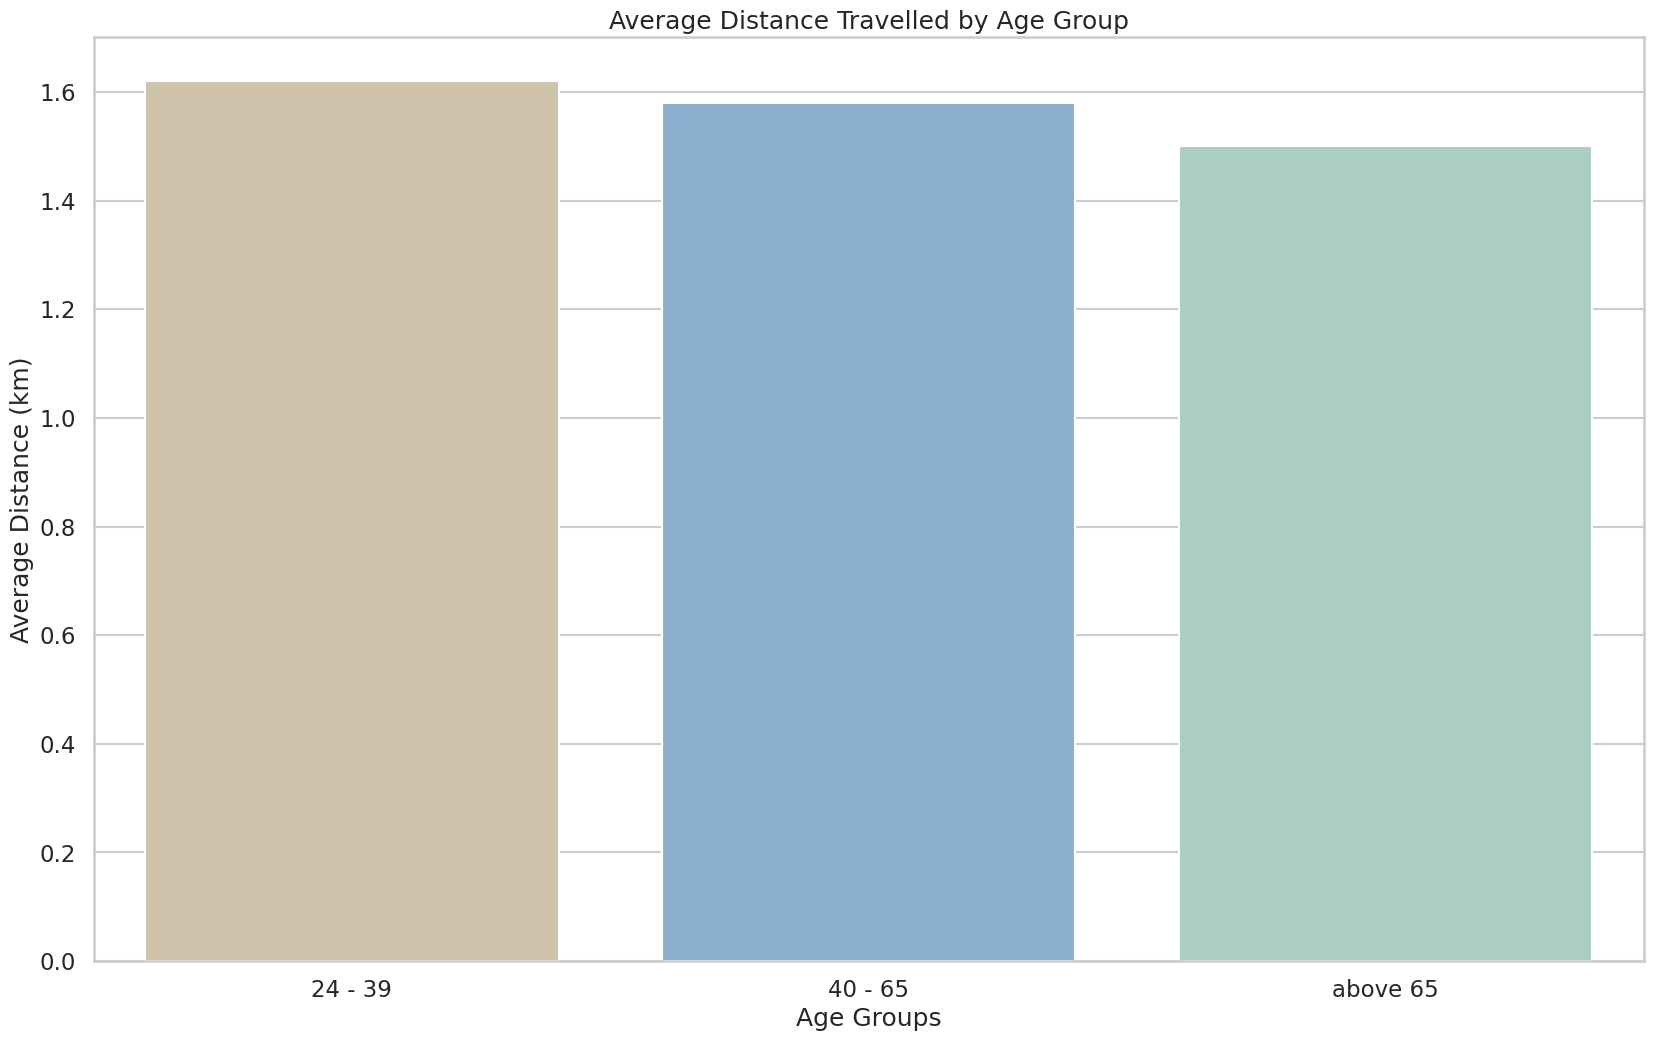

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert DataFrame to Pandas DataFrame
df_pandas = df_avg_distance_by_age_group.toPandas()
plt.figure(figsize=(20, 12))
palette_colors = ["#d4c4a5", "#7eb0db" ,"#a5d4c4"]


# Create bar plot
sns.barplot(x="age_group", y="avg_distance_km", data=df_pandas, palette = palette_colors)

# Add axis labels and title
plt.xlabel("Age Groups")
plt.ylabel("Average Distance (km)")
plt.title("Average Distance Travelled by Age Group")

# Show the plot
plt.show()


In [ ]:
## calculate the total cost for all customers and all subscribers

In [ ]:
df.columns

['start_time',
 'end_time',
 'start_station_id',
 'start_station_name',
 'start_station_latitude',
 'start_station_longitude',
 'end_station_id',
 'end_station_name',
 'end_station_latitude',
 'end_station_longitude',
 'bike_id',
 'user_type',
 'member_birth_year',
 'member_gender',
 'payment',
 'start_time_ts',
 'end_time_ts',
 'duration_sec',
 'duration_min']

In [ ]:
total_cost_user_type=df_fee.groupBy('user_type').agg(sum('fee'))

In [ ]:
total_cost_user_type.show()

+----------+-----------------+
| user_type|         sum(fee)|
+----------+-----------------+
|Subscriber|1487599.347499988|
|  Customer|750589.9858333278|
+----------+-----------------+



In [ ]:
##- what is the ratio of payment using cc or app wallet
df.columns

['start_time',
 'end_time',
 'start_station_id',
 'start_station_name',
 'start_station_latitude',
 'start_station_longitude',
 'end_station_id',
 'end_station_name',
 'end_station_latitude',
 'end_station_longitude',
 'bike_id',
 'user_type',
 'member_birth_year',
 'member_gender',
 'payment',
 'start_time_ts',
 'end_time_ts',
 'duration_sec',
 'duration_min']

In [ ]:
# Rename the column "pyr\r" to "payment"
# df = df.withColumnRenamed("pyment\r", "payment")


In [ ]:
df.columns

['start_time',
 'end_time',
 'start_station_id',
 'start_station_name',
 'start_station_latitude',
 'start_station_longitude',
 'end_station_id',
 'end_station_name',
 'end_station_latitude',
 'end_station_longitude',
 'bike_id',
 'user_type',
 'member_birth_year',
 'member_gender',
 'payment',
 'start_time_ts',
 'end_time_ts',
 'duration_sec',
 'duration_min']

In [ ]:
# Group how many users by payment method 
users_by_payment_method = (
    df.groupBy("payment")
    .agg(count("*").alias("total_pay_method"))
)


In [ ]:
users_by_payment_method.show()

+-----------+----------------+
|    payment|total_pay_method|
+-----------+----------------+
| app wallet|          260061|
|credit card|          259639|
+-----------+----------------+



In [ ]:
# Finding the ratio for both methods 
total_users = df.count()
users_by_payment_method = (
    users_by_payment_method
    .withColumn("ratio", col("total_pay_method") / total_users)
)

In [ ]:
users_by_payment_method.show()

+-----------+----------------+-------------------+
|    payment|total_pay_method|              ratio|
+-----------+----------------+-------------------+
| app wallet|          260061| 0.5004060034635367|
|credit card|          259639|0.49959399653646336|
+-----------+----------------+-------------------+



In [ ]:
##- what is the preferred way to pay for customers and subscriber

In [ ]:
## plotted with coparation between costumers and supscribers code 

payment_counts = df.groupBy('user_type', 'payment').agg(count("*").alias("count"))


In [ ]:
payment_counts.show()

+----------+-----------+------+
| user_type|    payment| count|
+----------+-----------+------+
|Subscriber| app wallet|204727|
|  Customer| app wallet| 55334|
|  Customer|credit card| 55136|
|Subscriber|credit card|204503|
+----------+-----------+------+



In [ ]:
##- is there a trend where younger users pay by card or wallet, what bout older users?


In [ ]:
# Join the two dataframes
df_joined = df_with_age.join(df, "bike_id")


root
 |-- bike_id: string (nullable = true)
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- payment: string (nullable = true)
 |-- start_time_ts: timestamp (nullable = true)
 |-- end_time_ts: timestamp (nullable = true)
 |-- duration_sec: long (nullable = true)
 |-- duration_min: double (nullable = true)
 |-- distance: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- start_time: string (nullable = tr

In [ ]:
df_with_age.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- payment: string (nullable = true)
 |-- start_time_ts: timestamp (nullable = true)
 |-- end_time_ts: timestamp (nullable = true)
 |-- duration_sec: long (nullable = true)
 |-- duration_min: double (nullable = true)
 |-- distance: double (nullable = true)
 |-- age: integer (nullable = true)



In [ ]:
df_joined = df_joined.withColumnRenamed("payment", "payments")

In [ ]:
# Select only the relevant columns
df_relevant = df_with_age.select("age","payment")
df_relevant.show()

+----+-----------+
| age|    payment|
+----+-----------+
|  36|credit card|
|  58|credit card|
|null|credit card|
|null|credit card|
|  26| app wallet|
|null| app wallet|
|  32| app wallet|
|null| app wallet|
|null| app wallet|
|null| app wallet|
|null|credit card|
|null| app wallet|
|  33|credit card|
|  33| app wallet|
|null|credit card|
|  43|credit card|
|  44| app wallet|
|null| app wallet|
|  35| app wallet|
|  52|credit card|
+----+-----------+
only showing top 20 rows



In [ ]:

# Add age_group column based on age
df_relevant = df_relevant.withColumn("age_group", when((col("age") >= 24) & (col("age") <= 39), "24 - 39")
                                             .when((col("age") >= 39) & (col("age") <= 65), "39 - 65")
                                             .otherwise("above 65"))

# Group by age_group and payment and calculate count
df_age_payment = df_relevant.groupBy("age_group", "payment").count()


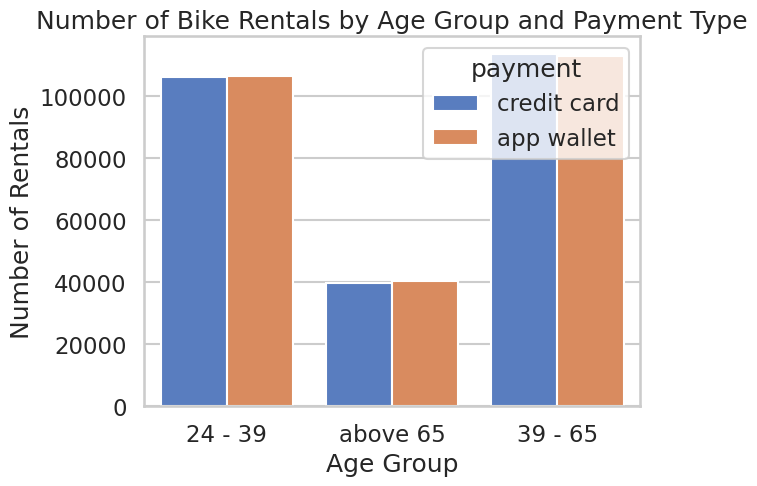

In [ ]:
# Create the bar plot
df_age_payment = df_age_payment.toPandas()
sns.barplot(x="age_group", y="count", hue="payment", data=df_age_payment, palette="muted")

# Set plot title and axes labels
plt.title("Number of Bike Rentals by Age Group and Payment Type")
plt.xlabel("Age Group")
plt.ylabel("Number of Rentals")

# Show the plot
plt.show()

In [ ]:
df_age_payment.show()

+---------+-----------+------+
|age_group|    payment| count|
+---------+-----------+------+
|  24 - 39|credit card|106267|
| above 65| app wallet| 40229|
| above 65|credit card| 39729|
|  24 - 39| app wallet|106663|
|  39 - 65| app wallet|113169|
|  39 - 65|credit card|113643|
+---------+-----------+------+



In [ ]:
# Convert pandas DataFrame to Spark DataFrame
df_age_payment_spark = spark.createDataFrame(df_age_payment)

# Calculate total count of payments in each age_group
df_total_payments = df_age_payment_spark.groupBy("age_group").agg(sum("count").alias("total_payments"))

# Join the two dataframes on age_group
df_ratio = df_age_payment_spark.join(df_total_payments, "age_group")

# Calculate the ratio of each payment type in each age group
df_ratio = df_ratio.withColumn("ratio", col("count") / col("total_payments"))

# Show the result
age_group_paymethods = df_ratio.select('age_group' , 'total_payments' , 'payment' , 'ratio').show()



+---------+--------------+-----------+-------------------+
|age_group|total_payments|    payment|              ratio|
+---------+--------------+-----------+-------------------+
| above 65|         79958| app wallet| 0.5031266414867805|
| above 65|         79958|credit card|0.49687335851321945|
|  24 - 39|        212930|credit card| 0.4990701169398394|
|  24 - 39|        212930| app wallet| 0.5009298830601606|
|  39 - 65|        226812| app wallet| 0.4989550817417068|
|  39 - 65|        226812|credit card| 0.5010449182582932|
+---------+--------------+-----------+-------------------+



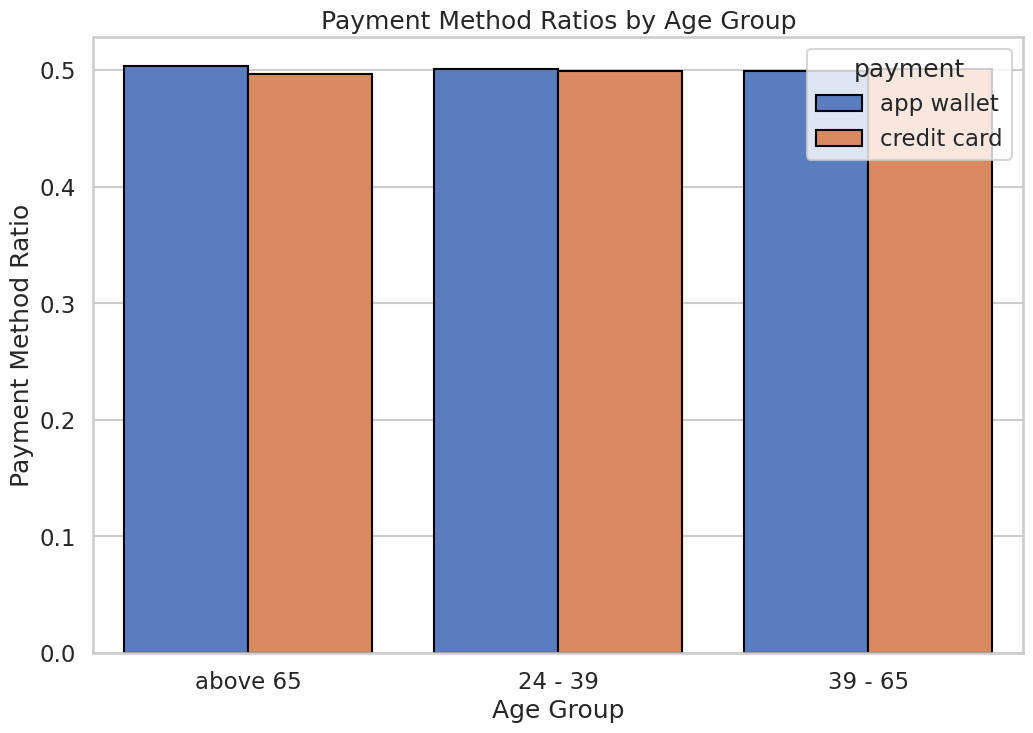

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame
age_group_paymethods_pd = df_ratio.toPandas()

# Set the figure size
plt.figure(figsize=(12, 8))

# Create the bar plot
sns.barplot(x="age_group", y="ratio", hue="payment", data=age_group_paymethods_pd,
            palette="muted", edgecolor="black")

# Set plot title and axes labels
plt.title("Payment Method Ratios by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Payment Method Ratio")

# Show the plot
plt.show()



In [ ]:
# # Convert the Spark DataFrame to a Pandas DataFrame
# age_group_paymethods_pd = age_group_paymethods.toPandas()

# # Define the palette of colors to use
# palette_colors = ["#a5d4c4", "#db7eaa", "#c4a5d4", "#7edbaa", "#d4c4aa", "#7eaddb"]

# # Create the bar plot
# ax = sns.barplot(x="age_group", y="ratio", hue="payment", data=age_group_paymethods_pd, palette=palette_colors)

# # Set the title and axis labels
# ax.set_title("Payment Methods by Age Group")
# ax.set_xlabel("Age Group")
# ax.set_ylabel("Ratio of Payment Method")

# # Add grid lines to the chart
# ax.grid(True)

# # Show the plot
# plt.show()

AttributeError: ignored

In [ ]:
df.count()

519700

) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


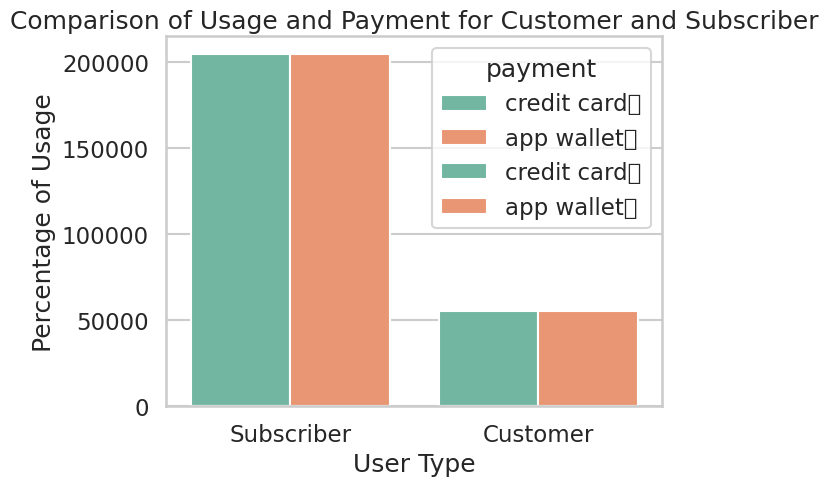

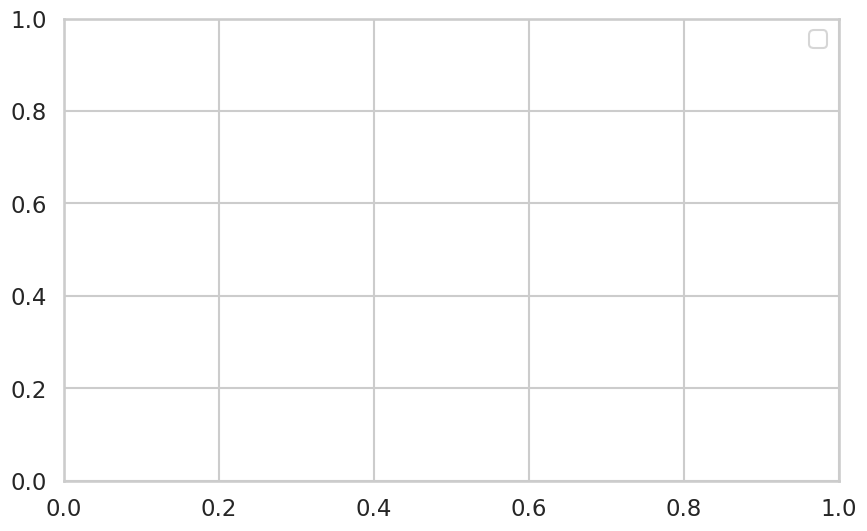

In [ ]:
## combining the total of usage for customers and subscribers with thier fees 

df_joined_pd = df_joined.toPandas()
payment_counts_pd = payment_counts.toPandas()



# Group the trips by user type and calculate the total duration
total_duration_by_user_type = (
    df.groupBy("user_type")
    .agg(expr("sum(duration_min) as total_duration"))
)

# Calculate the percentage of usage for each user type
trips_by_user_type = (
    df.groupBy("user_type")
    .agg(expr("count(*) as total_trips_users"))
    .join(total_duration_by_user_type, "user_type")
    .withColumn(
        "percentage_of_usage",
        expr("total_trips_users / sum(total_trips_users) over () * 100")
    )
)

# Group the trips by user type and payment type and calculate the count
payment_counts = df.groupBy('user_type', 'payment').agg(count("*").alias("count"))

# Join the two dataframes on user_type column
df_joined = trips_by_user_type.join(payment_counts, "user_type")

# Convert the Spark DataFrame to a Pandas DataFrame
df_joined_pd = df_joined.toPandas()

# Plot the results using Seaborn
sns.set_style("whitegrid")

ax = sns.barplot(x="user_type", y="count", hue="payment", data=payment_counts_pd, palette="Set2", width=0.8)
# Set the title and axis labels
ax.set_title("Comparison of Usage and Payment for Customer and Subscriber")
ax.set_xlabel("User Type")
ax.set_ylabel("Percentage of Usage")

# Set the figure size and adjust the legend location
plt.figure(figsize=(10,6))
plt.legend(loc='upper right')

# Show the plot
plt.show()
